In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import admix
import pickle
from admix.data import hdi
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [2]:
# setup
LEGEND_FS = 9
COMPILE_DATA = True

# Compile data

In [3]:
if COMPILE_DATA:
    #####################
    ###### panel a ######
    #####################
    with open(
        "../experiments/01-genome-wide-simulate-profile-likelihood/cache/dict_res.pkl",
        "rb",
    ) as f:
        dict_res = pickle.load(f)

    dict_loglik = dict_res["loglik"]
    df_plot = []
    pcausal = 0.001
    for hsq in [0.1, 0.25, 0.5]:
        for cor in [0.9, 0.95, 1.0]:
            for grm_prefix in ["hm3", "imputed"]:
                loglik = dict_loglik[
                    (
                        f"hsq-{hsq}-pcausal-{pcausal}-cor-{cor}-hermodel-mafukb",
                        f"{grm_prefix}.mafukb.005",
                    )
                ]
                mode = loglik.argmax() / 1000
                lower_ci, upper_ci = hdi(np.linspace(0, 1, 1001), loglik)
                df_plot.append(
                    [hsq, pcausal, cor, grm_prefix, mode, lower_ci, upper_ci]
                )
    df_plot = pd.DataFrame(
        df_plot,
        columns=["hsq", "pcausal", "cor", "snpset", "mode", "lower_ci", "upper_ci"],
    )
    df_plot.to_csv("data/Figure2a.csv", index=False)

    #####################
    ###### panel b ######
    #####################
    with open(
        "../experiments/01-genome-wide-simulate-profile-likelihood/cache_rv1/dict_res.pop-specific.pkl",
        "rb",
    ) as f:
        dict_res = pickle.load(f)

    dict_loglik = dict_res["loglik"]
    dict_pval = dict_res["pval"]
    df_plot = []
    pcausal = 0.001

    xs = np.linspace(0, 1, 1001)
    for cor in [0.9, 0.95, 1.0]:
        for maf in ["005", "01", "05"]:
            key = (
                f"hsq-0.25-pcausal-0.001-cor-{cor}-hermodel-mafukb",
                f"imputed.mafukb.{maf}",
            )
            loglik = dict_loglik[key]
            pval = np.array(dict_pval[key])

            mode = xs[loglik.argmax()]
            lower_ci, upper_ci = hdi(xs, loglik)
            df_plot.append(
                [
                    cor,
                    maf,
                    mode,
                    lower_ci,
                    upper_ci,
                    np.mean(pval < 0.05),
                ]
            )
    df_plot = pd.DataFrame(
        df_plot,
        columns=[
            "cor",
            "maf",
            "mode",
            "lower_ci",
            "upper_ci",
            "prob_reject",
        ],
    )
    df_plot.to_csv("data/Figure2b.csv", index=False)

    df_plot = []

    for prior in ["lt0", "lt-1"]:
        if prior == "lt0":
            with open(
                "../experiments/01-genome-wide-simulate-profile-likelihood/cache/dict_res.pkl",
                "rb",
            ) as f:
                dict_res = pickle.load(f)
            xs = np.linspace(0, 1, 1001)
        else:
            with open(
                "../experiments/01-genome-wide-simulate-profile-likelihood/cache_rv1/dict_res.pkl",
                "rb",
            ) as f:
                dict_res = pickle.load(f)
            xs = np.linspace(-1, 1, 2001)
        dict_loglik = dict_res["loglik"]
        dict_pval = dict_res["pval"]

        for cor in [0.9, 0.95, 1.0]:
            key = (
                f"hsq-0.25-pcausal-0.001-cor-{cor}-hermodel-mafukb",
                f"imputed.mafukb.005",
            )
            loglik = dict_loglik[key]

            pval = np.array(dict_pval[key])

            mode = xs[loglik.argmax()]
            lower_ci, upper_ci = hdi(xs, loglik)
            df_plot.append(
                [
                    prior,
                    cor,
                    mode,
                    lower_ci,
                    upper_ci,
                    np.mean(pval < 0.05),
                ]
            )

    df_plot = pd.DataFrame(
        df_plot,
        columns=[
            "prior",
            "cor",
            "mode",
            "lower_ci",
            "upper_ci",
            "prob_reject",
        ],
    )
    df_plot.to_csv("data/Figure2c.csv", index=False)

# Panel a

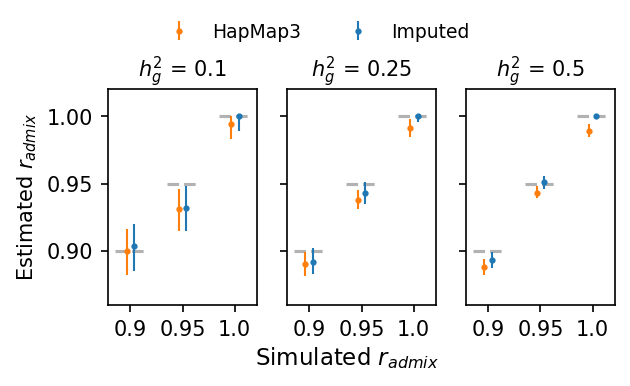

In [4]:
df_plot = pd.read_csv("data/Figure2a.csv")

snpset_list = ["HapMap3", "Imputed"]
fig, axes = plt.subplots(figsize=(4.3, 2.2), dpi=150, ncols=3, sharey=True)
for i_hsq, hsq in enumerate([0.1, 0.25, 0.5]):
    for i_snpset, snpset in enumerate(["hm3", "imputed"]):
        df_tmp = df_plot[(df_plot.snpset == snpset) & (df_plot.hsq == hsq)]

        axes[i_hsq].errorbar(
            x=np.arange(len(df_tmp)) + (i_snpset - 0.5) * 0.15,
            y=df_tmp["mode"],
            yerr=(
                df_tmp["mode"] - df_tmp["lower_ci"],
                df_tmp["upper_ci"] - df_tmp["mode"],
            ),
            fmt=".",
            ms=4,
            mew=1,
            lw=1,
            color=["C1", "C0"][i_snpset],
            label=snpset_list[i_snpset],
        )

    # box plots
    # x-axis
    axes[i_hsq].set_xticks([0, 1, 2])
    axes[i_hsq].set_xticklabels([0.9, 0.95, 1.0])

    # y-axis
    axes[i_hsq].set_ylim(0.86, 1.02)
    if i_hsq == 0:
        axes[i_hsq].set_ylabel("Estimated $r_{admix}$")

    # title
    axes[i_hsq].set_title(f"$h_g^2$ = {hsq}", fontsize=10)
    for i_cor, cor in enumerate([0.9, 0.95, 1.0]):
        axes[i_hsq].hlines(
            y=cor,
            xmin=i_cor - 0.3,
            xmax=i_cor + 0.3,
            color="gray",
            ls="--",
            alpha=0.6,
            zorder=-10,
        )

fig.text(
    0.55,
    -0.01,
    "Simulated $r_{admix}$",
    fontsize=11,
    ha="center",
)

handles, labels = axes[0].get_legend_handles_labels()

fig.legend(
    handles,
    labels,
    ncol=6,
    loc="center",
    bbox_to_anchor=[0.5, 1.0],
    frameon=False,
    fontsize=LEGEND_FS,
)

fig.tight_layout()
fig.savefig("out/Figure2a.pdf", bbox_inches="tight")

# Panel B

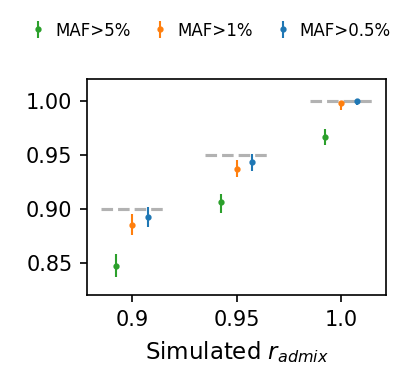

In [5]:
df_plot = pd.read_csv("data/Figure2b.csv", dtype={"maf": str})

maf_list = ["MAF>5%", "MAF>1%", "MAF>0.5%"]
fig, ax = plt.subplots(figsize=(2.7, 2.2), dpi=150, ncols=1, sharey=True)

for i_maf, maf in enumerate(["05", "01", "005"]):
    df_tmp = df_plot[(df_plot.maf == maf)]

    ax.errorbar(
        x=np.arange(len(df_tmp)) + (i_maf - 1) * 0.15,
        y=df_tmp["mode"],
        yerr=(
            df_tmp["mode"] - df_tmp["lower_ci"],
            df_tmp["upper_ci"] - df_tmp["mode"],
        ),
        fmt=".",
        ms=4,
        mew=1,
        lw=1,
        color=["C2", "C1", "C0"][i_maf],
        label=maf_list[i_maf],
    )

# box plots
# x-axis
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([0.9, 0.95, 1.0])

# y-axis
ax.set_ylim(0.82, 1.02)
# ax.set_ylabel("Estimated $r_{admix}$")

# title
for i_cor, cor in enumerate([0.9, 0.95, 1.0]):
    ax.hlines(
        y=cor,
        xmin=i_cor - 0.3,
        xmax=i_cor + 0.3,
        color="gray",
        ls="--",
        alpha=0.6,
        zorder=-10,
    )


ax.set_xlabel(
    "Simulated $r_{admix}$",
    fontsize=11,
)
fig.legend(
    ncol=3,
    loc="center",
    bbox_to_anchor=[0.5, 1.08],
    frameon=False,
    fontsize=LEGEND_FS - 1,
    columnspacing=0.8,
    handletextpad=0,
)
fig.tight_layout()
fig.savefig("out/Figure2b.pdf", bbox_inches="tight")

# Panel C

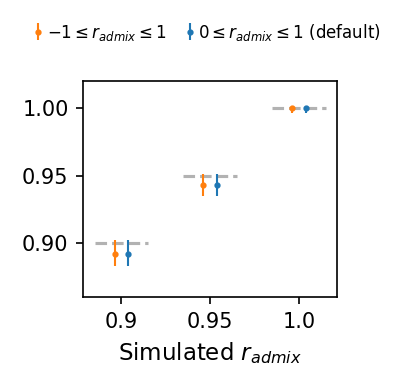

In [6]:
df_plot = pd.read_csv("data/Figure2c.csv")

prior_list = ["$-1 \leq r_{admix} \leq 1$", "$0 \leq r_{admix} \leq 1$ (default)"]
fig, ax = plt.subplots(figsize=(2.4, 2.2), dpi=150)

for i_prior, prior in enumerate(["lt-1", "lt0"]):
    df_tmp = df_plot[(df_plot.prior == prior)]
    ax.errorbar(
        x=np.arange(len(df_tmp)) + (i_prior - 0.5) * 0.15,
        y=df_tmp["mode"],
        yerr=(
            df_tmp["mode"] - df_tmp["lower_ci"],
            df_tmp["upper_ci"] - df_tmp["mode"],
        ),
        fmt=".",
        ms=4,
        mew=1,
        lw=1,
        color=["C1", "C0"][i_prior],
        label=prior_list[i_prior],
    )

# box plots
# x-axis
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([0.9, 0.95, 1.0])

# y-axis
ax.set_ylim(0.86, 1.02)
# ax.set_ylabel("Estimated $r_{admix}$")

# title
for i_cor, cor in enumerate([0.9, 0.95, 1.0]):
    ax.hlines(
        y=cor,
        xmin=i_cor - 0.3,
        xmax=i_cor + 0.3,
        color="gray",
        ls="--",
        alpha=0.6,
        zorder=-10,
    )


ax.set_xlabel(
    "Simulated $r_{admix}$",
    fontsize=11,
)
fig.legend(
    ncol=2,
    loc="center",
    bbox_to_anchor=[0.56, 1.08],
    frameon=False,
    fontsize=LEGEND_FS - 1,
    columnspacing=0.4,
    handletextpad=-0.5,
)
fig.tight_layout()
fig.savefig("out/Figure2c.pdf", bbox_inches="tight")